In [54]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from two_layer_net import TwoLayerNet
from keras.datasets import mnist
from common.functions import softmax

%matplotlib inline

In [55]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 1次元へ整形
x_train, x_test = x_train.reshape(-1, 784), x_test.reshape(-1, 784)

# 正規化
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [56]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# パラメータのロード
network.load_params("params_nn.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [57]:
true_idxs = [[], [], [], [], [], [], [], [], [], []]
for i, t in enumerate(x_test):
    pre_l = np.argmax(network.predict(t))
    true_l = t_test[i]
    if pre_l == true_l:
        true_idxs[true_l].append(i)

In [58]:
true_x_list = []
for i in range(10):
    true_nums = true_idxs[i][:10]
    true_x_list.append(list(map(lambda x: [x_test[x]], true_nums)))
    
true_x_list = np.array(true_x_list)
true_x_list.shape

(10, 10, 1, 784)

In [59]:
x = x_train[0].copy().reshape(1, 784)
print(x.shape)

(1, 784)


In [60]:
def generate_adv(x, label, network, eps=0.01):
    g = network.gradient(x, np.array([label]))
    g_w1 = g['W1']
    model_w1 = network.params['W1']
    affine1 = np.dot(x, model_w1)
    inverse = np.linalg.pinv(model_w1 + np.sign(g_w1) * eps)
    p = np.dot(affine1, inverse)
    adv = (x + p).clip(min=0, max=1)
    return adv

In [61]:
generate_adv(x, 5, network, 0)

array([[0.00000000e+00, 1.45115867e-02, 4.49933539e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.00540879e-02, 0.00000000e+00,
        1.36463492e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.08275144e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.70768632e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.88423323e-02, 6.75746648e-02, 0.00000000e+00,
        6.92530212e-02, 0.00000000e+00, 1.24564385e-01, 2.74689838e-02,
        1.22080866e-02, 0.00000000e+00, 2.56257104e-02, 9.73307875e-02,
        0.00000000e+00, 9.80103066e-03, 1.45654789e-01, 0.00000000e+00,
        9.40899769e-02, 7.97625442e-02, 0.00000000e+00, 0.00000000e+00,
        8.24103674e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.13450148e-01, 5.82157790e-02, 3.44242988e-02, 7.97138476e-02,
        4.27913419e-03, 1.44998763e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [62]:
def generate_adv2(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x, np.array([label]))
#     plt.imshow(d.reshape(28, 28), 'gray')
#     plt.show()
    p = eps * np.sign(d)
    adv = (x - p).clip(min=0, max=1)
#     plt.imshow(adv.reshape(28, 28), 'gray')
#     plt.show()
    return adv

In [63]:
generate_adv2(x, 5, network, 0.5)

array([[0.        , 0.        , 0.5       , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.5       ,
        0.        , 0.5       , 0.        , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.        ,
        0.        , 0.        , 0.        , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.        , 0.5       , 0.        , 0.5       , 0.        ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.        ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.  

In [64]:
def compare_eps(x, label, network, eps_list):
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    ax = fig.add_subplot(5, 5, 1)
    ax.imshow(x.reshape(28,28), 'gray')
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 4)
    ax.set_title(f"base, {pre_label} : {pre_score}")

    for i, eps in enumerate(eps_list):
        adv = generate_adv2(x, label, network, eps)
        ax = fig.add_subplot(5, 5, i+2)
        ax.imshow(adv.reshape(28,28), 'gray')
        pre = network.predict(adv)
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 4)
        ax.set_title(f"eps[{eps}], {pre_label} : {pre_score}")

    plt.show()

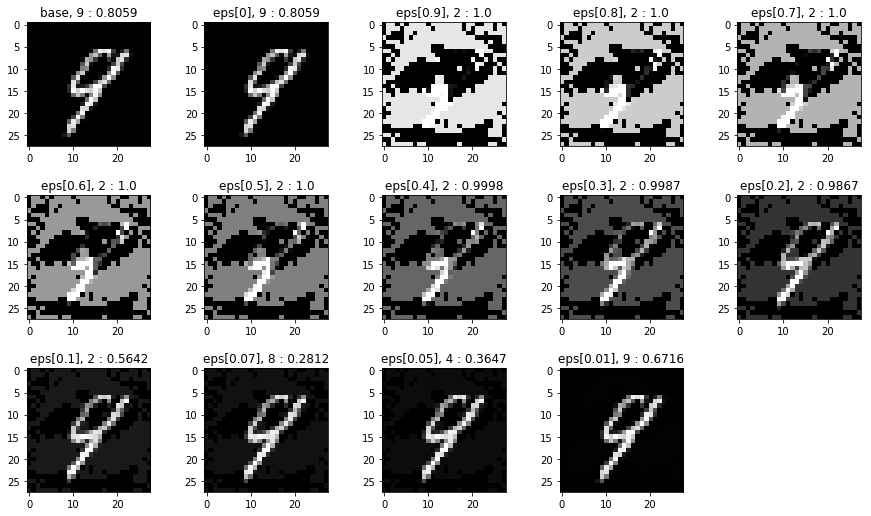

In [67]:
eps_list = [0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.07, 0.05, 0.01]
compare_eps(x, 5, network, eps_list)

0


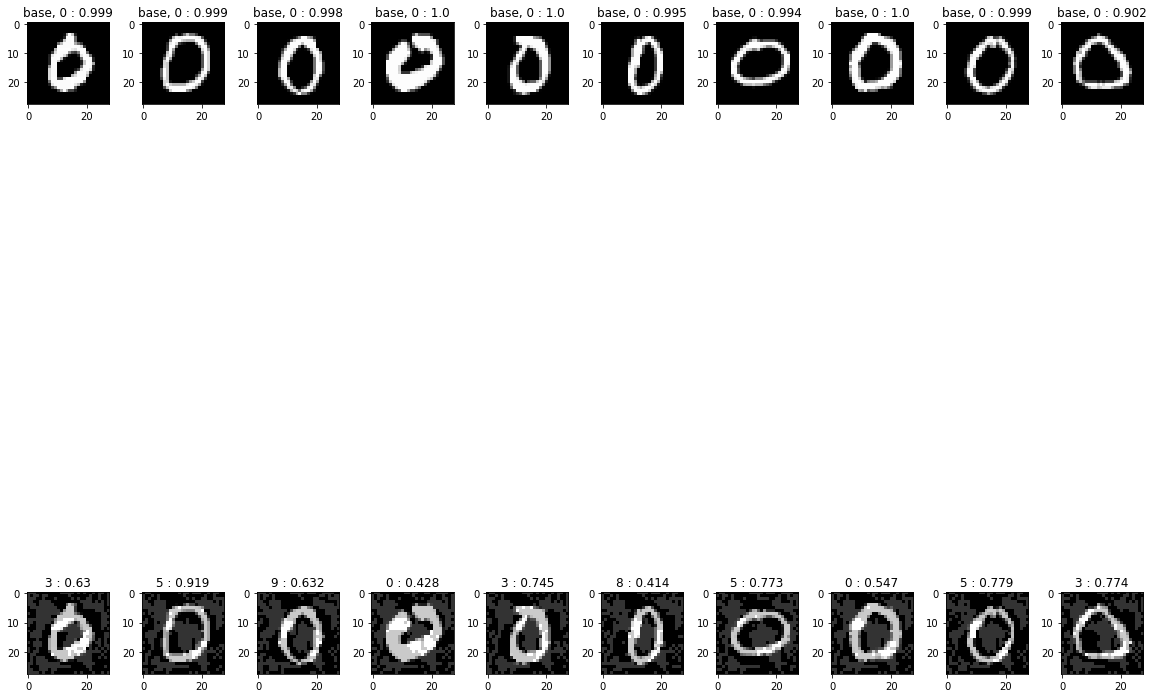

1


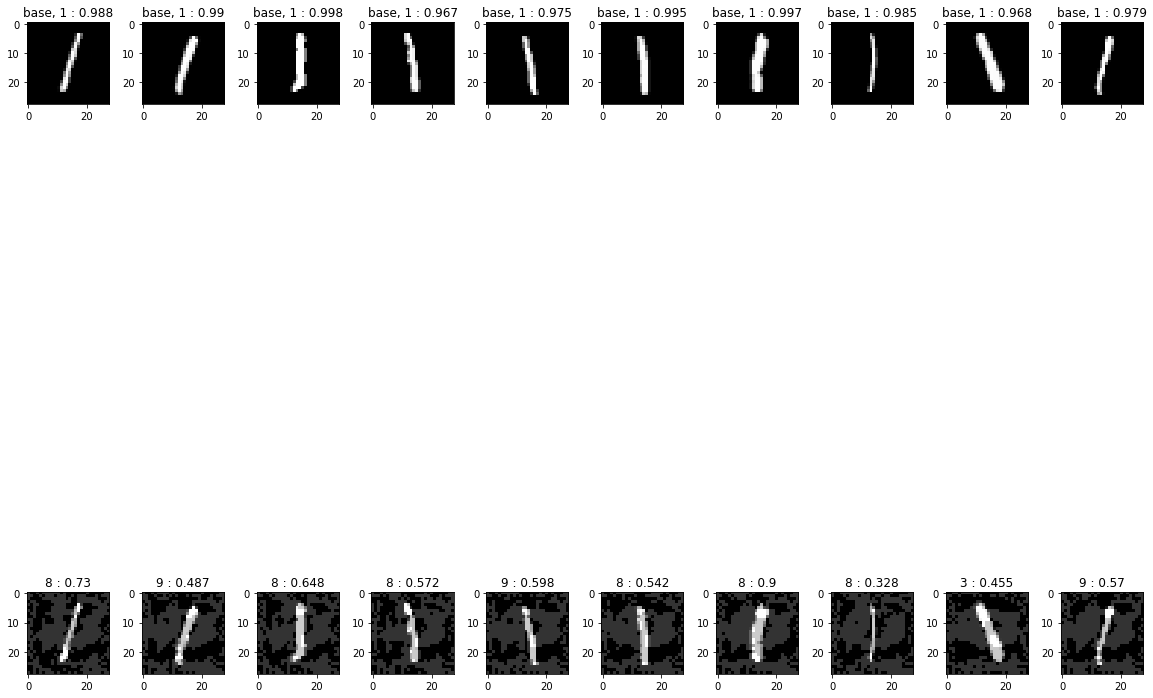

2


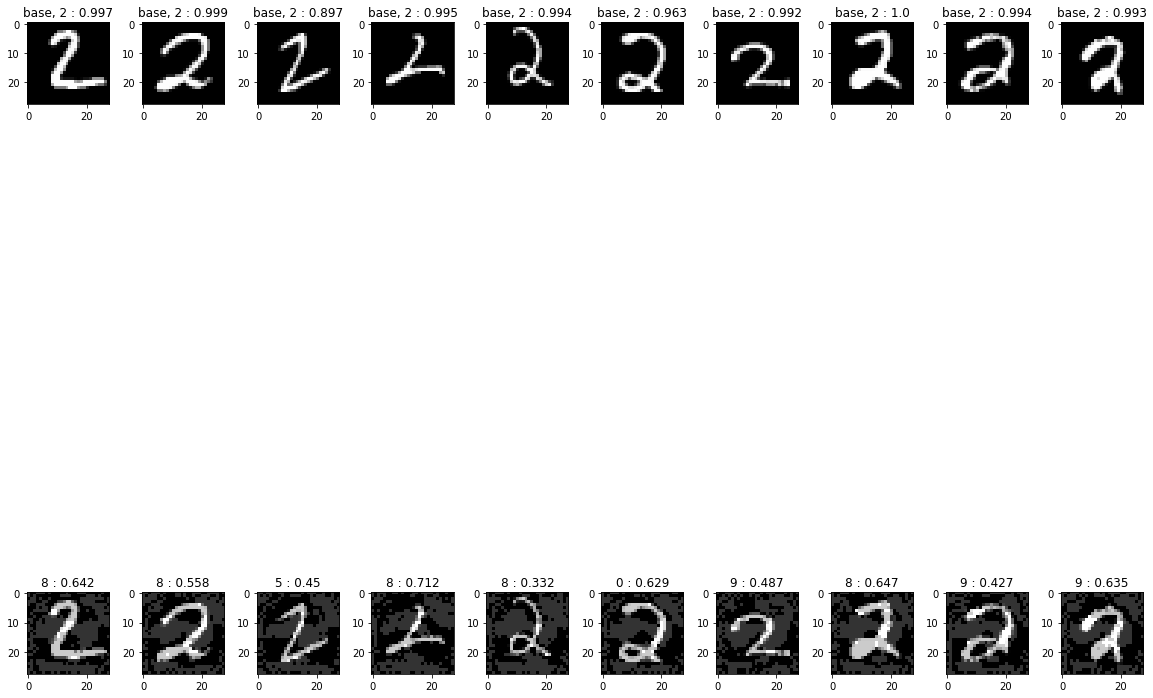

3


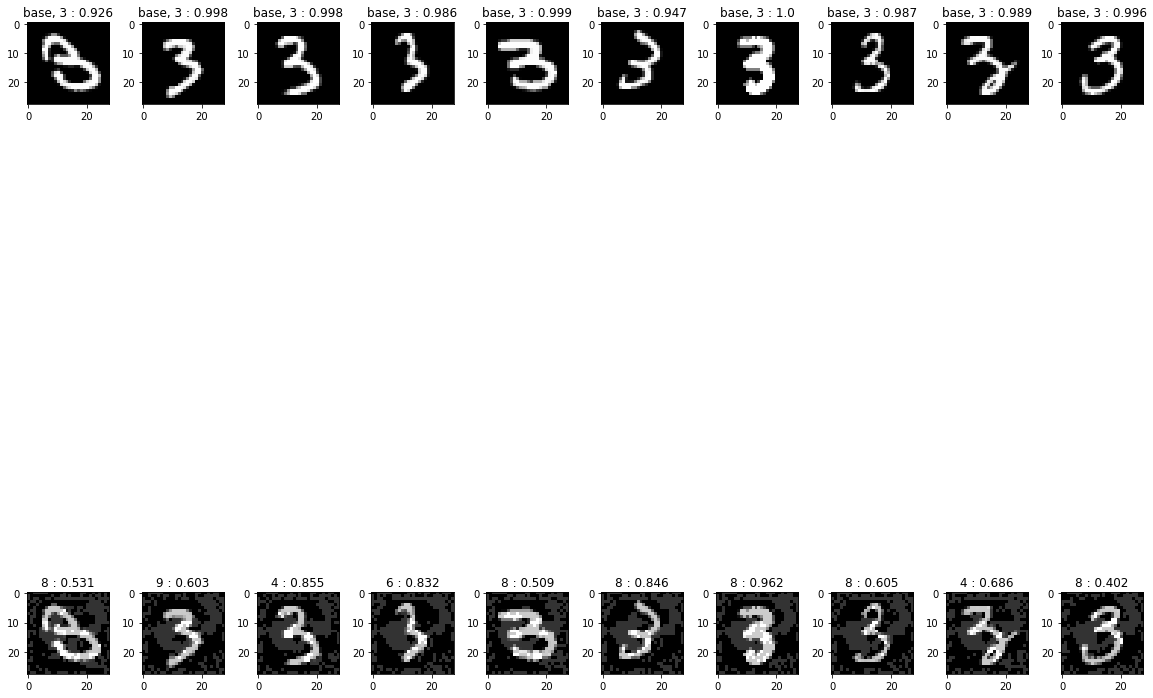

4


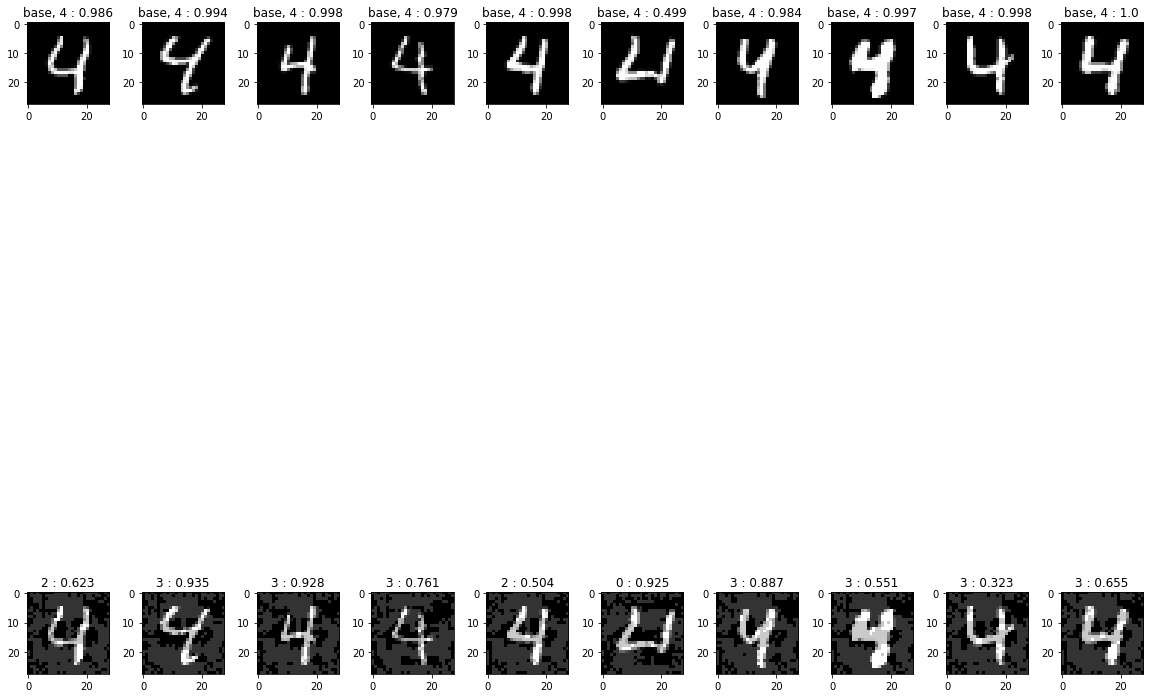

5


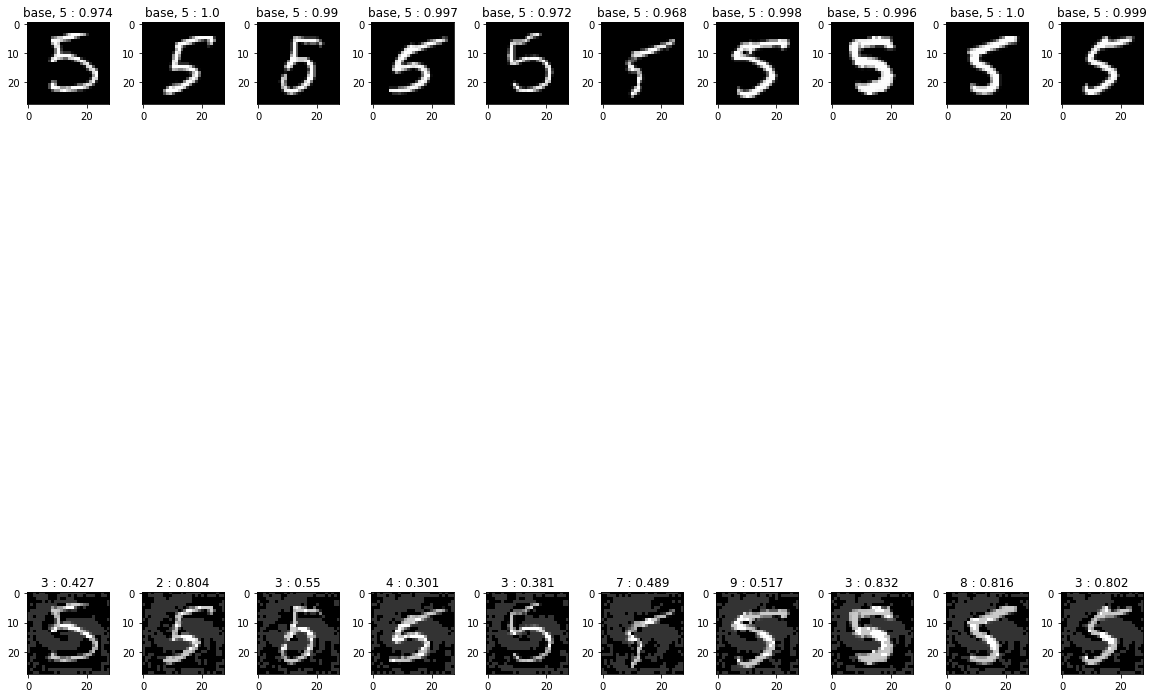

6


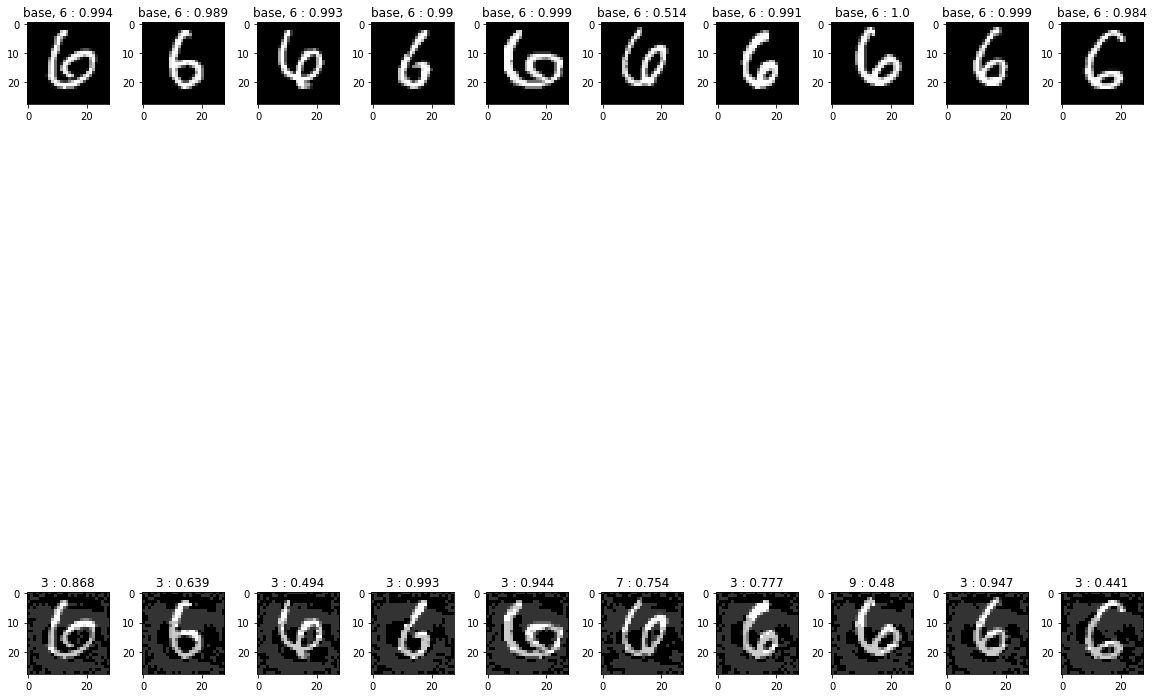

7


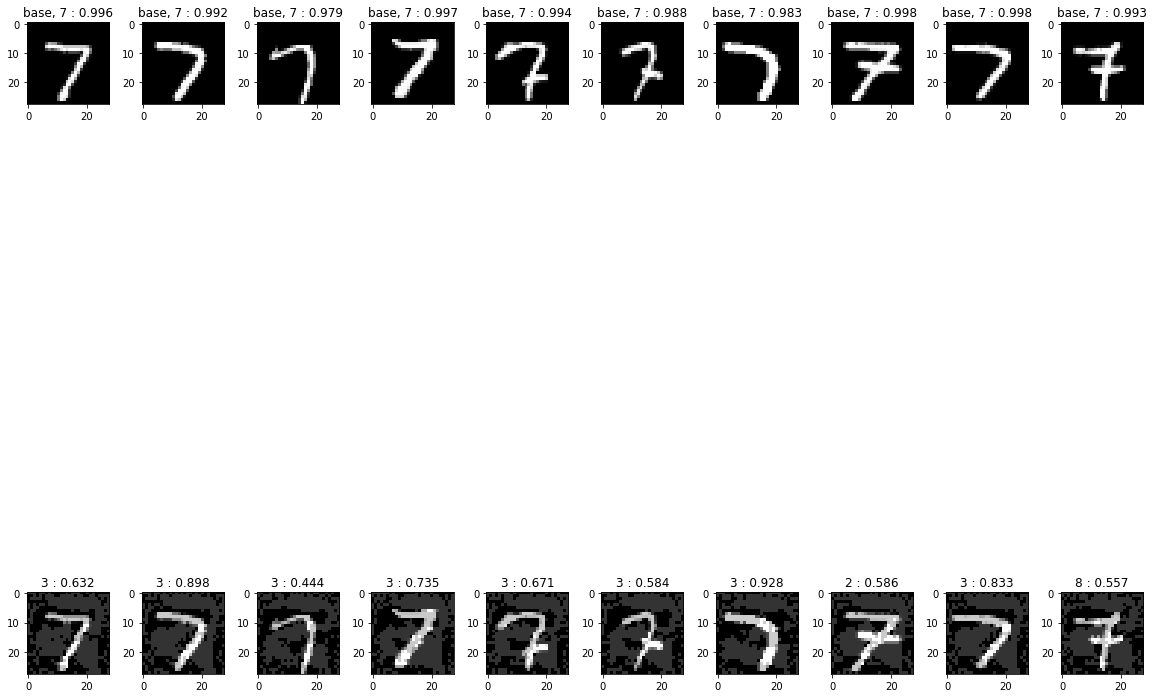

8


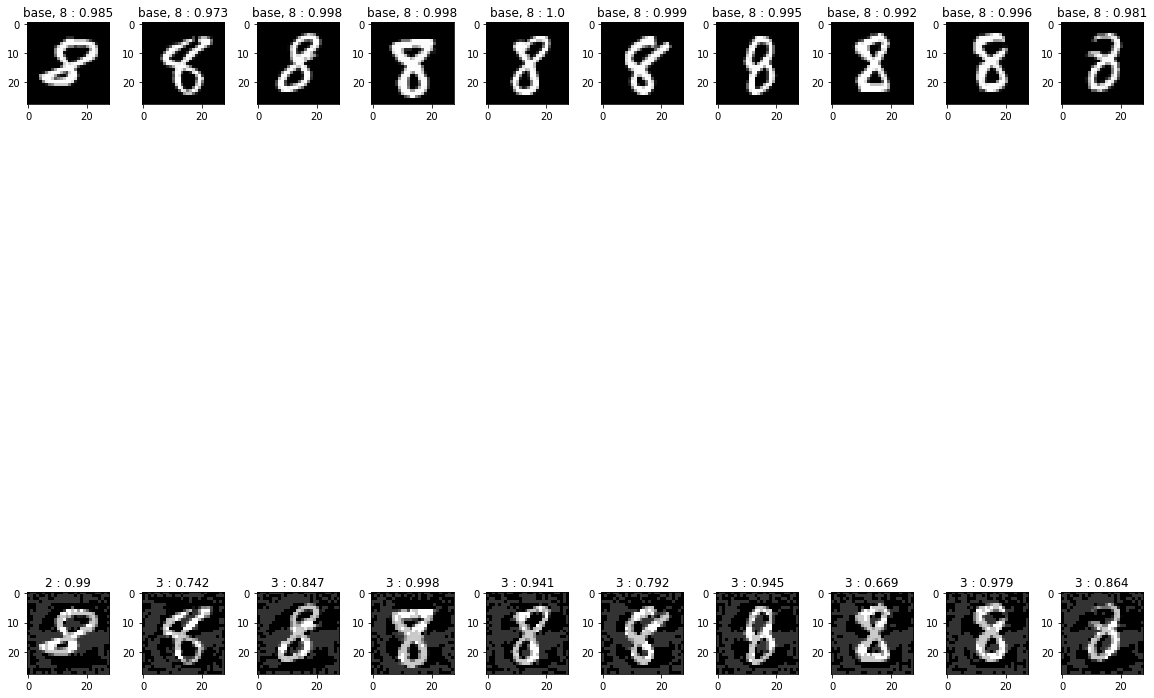

9


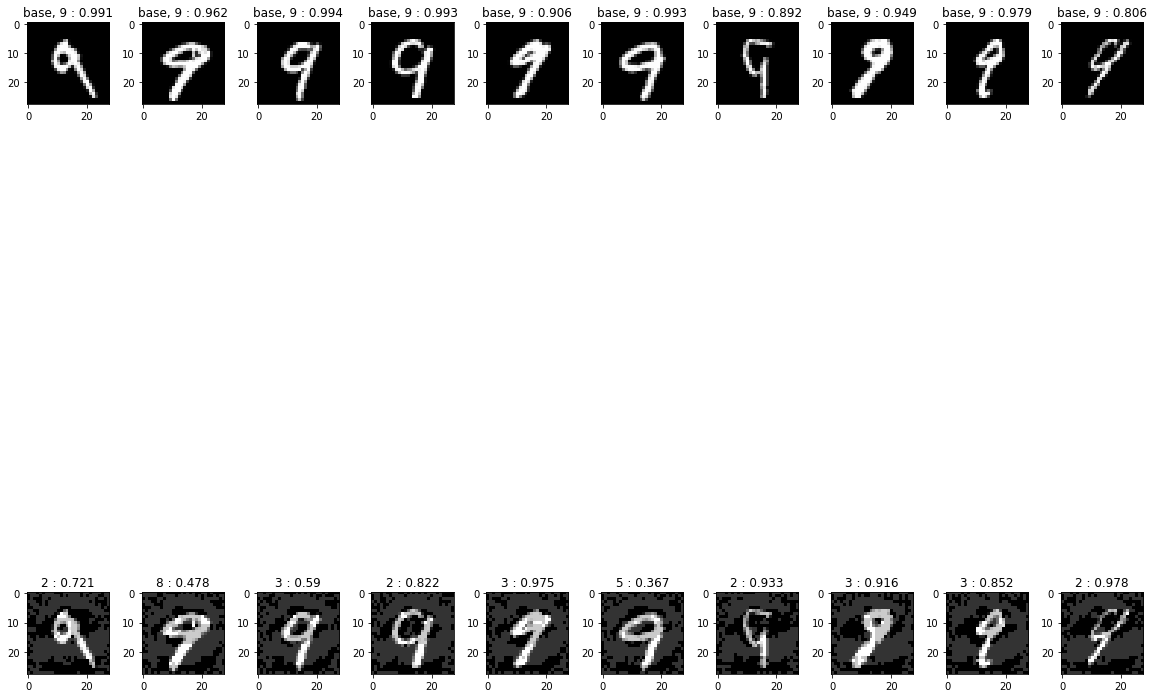

In [68]:
for i, nums in enumerate(true_x_list):
    print(i)
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(wspace=0.4, hspace=0.1)
    
    for j, x in enumerate(nums):
        ax = fig.add_subplot(2, 10, j+1)
        ax.imshow(x.reshape(28,28), 'gray')
        pre = network.predict(x)
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 3)
        ax.set_title(f"base, {pre_label} : {pre_score}")

        adv = generate_adv2(x, i, network, 0.2)
        ax = fig.add_subplot(2, 10, j+11)
        ax.imshow(adv.reshape(28,28), 'gray')
        pre = network.predict(adv)
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 3)
        ax.set_title(f"{pre_label} : {pre_score}")

    plt.show()